# Time Series with Gaussian Processes with Temperature Data
Adapted from: https://juanitorduz.github.io/gaussian_process_time_series/

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

## Importing the data and creating the train and test data:

In [162]:
scaler=StandardScaler()
df_initial = pd.read_csv('./Temp_Data/data.csv')
y=df_initial['Value'].values
X=df_initial['Years'].values
mask= ~np.isnan(y)
X=X[mask].reshape(-1,1)
#y=y[mask].reshape(-1,1)-np.mean(y[mask].reshape(-1,1))
y=scaler.fit_transform(y.reshape(-1,1))

In [163]:
# df_clean=df_final.copy()
# df_clean[df_clean.keys()[0]]=df_final.iloc[:,0].values+((df_final.iloc[:,(1)].values/12)-(1/12))
# df_clean.drop(df_clean.keys()[1],axis=1,inplace=True)


In [164]:
prop_train = 0.7
n=len(X)
n_train = round(prop_train * n)

X_train = X[:n_train].reshape(-1, 1)
y_train = y[:n_train].reshape(-1, 1)

X_test = X[n_train:].reshape(-1, 1)
y_test = y[n_train:].reshape(-1, 1)


 
The combination of kernels selected are from "Time Series Forecasting with Gaussian Processes Needs Priors" [\[1\]](https://arxiv.org/abs/2009.08102). specifically these ones:
- Linear
- Periodic
- Radial Basis Function (RBF)
- White Noise
- Spectral Mixture (SM)

From the paper, "Gaussian Process Kernels for Pattern Discovery and Extrapolation" [\[2\]](https://arxiv.org/abs/1302.4245), the spectral mixture kernel that is used in this notebook can model functions and other kernels such as the periodic and the matern kernels fail at modeling. WE are using the sinc function to test our SM kernel because that is one of the functions found in the above paper.

In [293]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel
from sklearn.gaussian_process.kernels import PairwiseKernel

Noise = ConstantKernel()*WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

Linear_k = ConstantKernel(constant_value=1e-3, constant_value_bounds=(1e-5, 1e-1)) * PairwiseKernel(metric='linear') #+ ConstantKernel(constant_value=1e-7, constant_value_bounds=(1e-8, 1e-6))

Periodic_k = ConstantKernel(constant_value=1, constant_value_bounds=(1e-5, 2))*ExpSineSquared(length_scale=0.2, periodicity=1.0, length_scale_bounds=(1e-5, 6.3), periodicity_bounds=(1e-5, 1e3))

RBF_k = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 3)) * RBF(length_scale=1.1, length_scale_bounds=(1e-5, 25))

SM1_k = ConstantKernel(constant_value=0.7, constant_value_bounds=(1e-5, 1.4)) * RBF(length_scale=0.7, length_scale_bounds=(1e-5, 3.5)) * ExpSineSquared(length_scale=1.0, periodicity=0.5, length_scale_bounds=(1, 1), periodicity_bounds=(1e-5, 1e1))

SM2_k = ConstantKernel(constant_value=0.7, constant_value_bounds=(1e-5, 1.4)) * RBF(length_scale=1.1, length_scale_bounds=(1e-5, 15.4)) * ExpSineSquared(length_scale=1.0, periodicity=1.6, length_scale_bounds=(1, 1), periodicity_bounds=(1e-5, 1e2))

K  =SM2_k+Noise+Linear_k+Periodic_k+RBF_k+SM1_k

In [294]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=K, 
    n_restarts_optimizer=50, 
    normalize_y=True,
    alpha=0.1)

Sampling the intial priors and showing the paths compared to the train data:

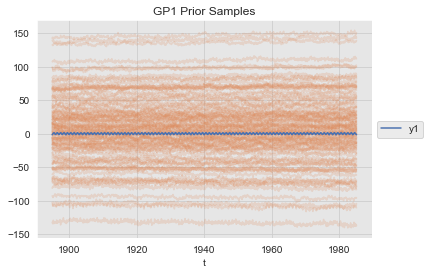

In [295]:
gp1_prior_samples = gp1.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp1_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t');

The same but with a portion of the data:

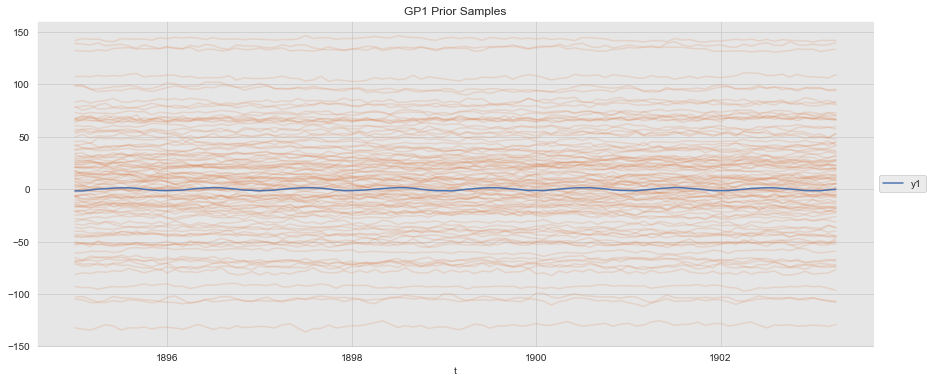

In [296]:
fig, ax = plt.subplots(figsize=(15,6))
for i in range(100):
    sns.lineplot(x=X_train[:100,0], y = gp1_prior_samples[:100, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[:100:,0], y=y_train[:100, 0], color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t');

In [297]:
gp1.fit(X_train, y_train)

C:\Users\magut\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\magut\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\magut\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

GaussianProcessRegressor(alpha=0.1,
                         kernel=0.837**2 * RBF(length_scale=1.1) * ExpSineSquared(length_scale=1, periodicity=1.6) + 1**2 * WhiteKernel(noise_level=0.09) + 0.0316**2 * PairwiseKernel(gamma=1.0, metric=linear) + 1**2 * ExpSineSquared(length_scale=0.2, periodicity=1) + 1**2 * RBF(length_scale=1.1) + 0.837**2 * RBF(length_scale=0.7) * ExpSineSquared(length_scale=1, periodicity=0.5),
                         n_restarts_optimizer=50, normalize_y=True)

In [298]:
y_pred, y_std = gp1.predict(X.reshape(-1,1), return_std=True)

df_results = pd.DataFrame({'t': X.ravel(), 'Temp. Anomaly': y.ravel(), 'Pred. Temp. Anomaly': y_pred.ravel(), 
                           'Upr Pred. Temp Std': (y_pred + 2 * y_std).ravel(), 'Lwr Pred. Temp Std': (y_pred - 2 * y_std).ravel()})
df_results

,t,Temp. Anomaly,Pred. Temp. Anomaly,Upr Pred. Temp Std,Lwr Pred. Temp Std
0,1895.000000,-1.666434,-1.477248,-1.419654,-1.534843
1,1895.083333,-1.672293,-1.245442,-1.187941,-1.302943
2,1895.166667,-0.801898,-0.732244,-0.674681,-0.789807
3,1895.250000,0.039852,-0.109678,-0.052111,-0.167245
4,1895.333333,0.498160,0.513757,0.571318,0.456196
...,...,...,...,...,...
1540,2023.333333,0.658307,0.528414,0.601905,0.454922
1541,2023.416667,1.088622,1.068382,1.141868,0.994896
1542,2023.500000,1.522192,1.376850,1.450341,1.303359
1543,2023.583333,1.437561,1.307756,1.381257,1.234256


We can now predict on the data:

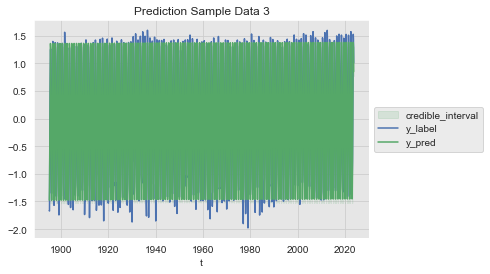

In [299]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_results['t'], 
    y1=df_results['Lwr Pred. Temp Std'],
    y2=df_results['Lwr Pred. Temp Std'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval')

sns.lineplot(x='t', y='Temp. Anomaly', data=df_results, color=sns_c[0], label = 'y_label', ax=ax)
sns.lineplot(x='t', y='Pred. Temp. Anomaly', data=df_results, color=sns_c[2], label='y_pred', ax=ax)

#ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 3', xlabel='t', ylabel='');


Here is the same but with a portion of the data:

[Text(0.5, 1.0, 'Prediction Sample Data 3'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

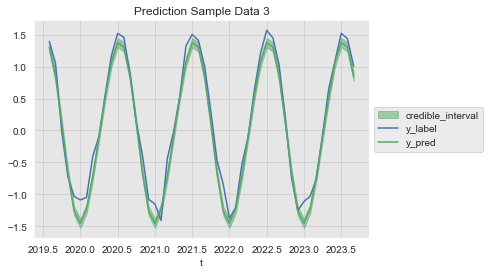

In [300]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_results['t'][-50:], 
    y1=df_results['Lwr Pred. Temp Std'][-50:],
    y2=df_results['Upr Pred. Temp Std'][-50:], 
    color=sns_c[2], 
    alpha=0.5, 
    label='credible_interval')

sns.lineplot(x='t', y='Temp. Anomaly', data=df_results.iloc[-50:,:], color=sns_c[0], label='y_label', ax=ax)
sns.lineplot(x=df_results['t'][-50:], y=df_results['Pred. Temp. Anomaly'][-50:], color=sns_c[2], label='y_pred', ax=ax)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 3', xlabel='t', ylabel='')


In [301]:
gp1.kernel_.get_params()

{'k1': 0.00434**2 * RBF(length_scale=14.1) * ExpSineSquared(length_scale=1, periodicity=100) + 0.00428**2 * WhiteKernel(noise_level=0.01) + 0.0252**2 * PairwiseKernel(gamma=1.0, metric=linear) + 1.01**2 * ExpSineSquared(length_scale=2.01, periodicity=1) + 0.00587**2 * RBF(length_scale=20.5),
 'k2': 0.00348**2 * RBF(length_scale=3.5) * ExpSineSquared(length_scale=1, periodicity=10),
 'k1__k1': 0.00434**2 * RBF(length_scale=14.1) * ExpSineSquared(length_scale=1, periodicity=100) + 0.00428**2 * WhiteKernel(noise_level=0.01) + 0.0252**2 * PairwiseKernel(gamma=1.0, metric=linear) + 1.01**2 * ExpSineSquared(length_scale=2.01, periodicity=1),
 'k1__k2': 0.00587**2 * RBF(length_scale=20.5),
 'k1__k1__k1': 0.00434**2 * RBF(length_scale=14.1) * ExpSineSquared(length_scale=1, periodicity=100) + 0.00428**2 * WhiteKernel(noise_level=0.01) + 0.0252**2 * PairwiseKernel(gamma=1.0, metric=linear),
 'k1__k1__k2': 1.01**2 * ExpSineSquared(length_scale=2.01, periodicity=1),
 'k1__k1__k1__k1': 0.00434**2 *

Checking the errors and $r^2$:

In [302]:
from sklearn.metrics import mean_absolute_error
print(f'R2 Score Train = {gp1.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1.predict(X_test)): 0.3f}')

R2 Score Train =  0.982
R2 Score Test =  0.974
MAE Train =  0.101
MAE Test =  0.121


C:\Users\magut\AppData\Local\Temp\ipykernel_35344\4239692173.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=errors, ax=ax[1])


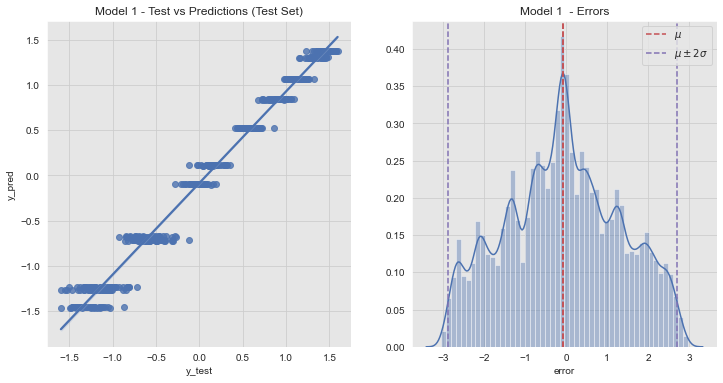

In [303]:
errors = gp1.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp1.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 1 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 1  - Errors', xlabel='error', ylabel=None);

In [3]:
import numpy as np
np.logspace(-1, 1, 25)

array([ 0.1       ,  0.12115277,  0.14677993,  0.17782794,  0.21544347,
        0.26101572,  0.31622777,  0.38311868,  0.46415888,  0.56234133,
        0.68129207,  0.82540419,  1.        ,  1.21152766,  1.46779927,
        1.77827941,  2.15443469,  2.61015722,  3.16227766,  3.83118685,
        4.64158883,  5.62341325,  6.81292069,  8.25404185, 10.        ])